# Custom Coco Dataset

# Resize Image Data

In [1]:
import json
from PIL import Image
import os

In [33]:
# Set the target size for resizing
# Raw images are 8/6 -> 8000x6000 pixels
original_shape = (1920, 1080)
target_size = (640, 640)
input_folder = "/Users/johannes/Code/Work/Exports/NanoStore_1920-1080"
original_json_file = os.path.join(input_folder, "result.json")
output_folder = "/Users/johannes/Code/labelstudio/combined_COCO"

In [3]:
def resize_images(input_folder, output_folder, target_size=(640, 640)):
    # Create the output folder if it doesn't exist
    output_images_folder = os.path.join(output_folder, "images")
    if not os.path.exists(output_images_folder):
        os.makedirs(output_images_folder)

    # List all files in the input folder
    files = os.listdir(input_folder)

    for file in files:
        if file.endswith(".png"):
            # Open the image
            image_path = os.path.join(input_folder, file)
            img = Image.open(image_path)

            # Resize the image
            resized_img = img.resize(target_size, Image.ANTIALIAS)

            # Save the resized image to the output folder
            output_path = os.path.join(output_images_folder, file)
            resized_img.save(output_path)

            print(f"Resized {file} to {target_size}")

In [4]:
# Resize images
resize_images(os.path.join(input_folder, 'images'), output_folder, target_size)

/var/folders/64/sth8xpv12c5858fnxytdg_200000gn/T/ipykernel_7853/2111692543.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


Resized 5400ff2f-vlcsnap-2024-03-10-11h03m44s897.png to (640, 640)
Resized 3dc3749a-vlcsnap-2024-03-10-11h03m52s538.png to (640, 640)
Resized dfaaed77-vlcsnap-2024-03-10-11h04m06s528.png to (640, 640)
Resized 11b21fcf-vlcsnap-2024-03-10-11h04m10s366.png to (640, 640)
Resized 21d921ff-vlcsnap-2024-03-10-11h55m34s938.png to (640, 640)
Resized 85956009-vlcsnap-2024-03-10-11h04m18s343.png to (640, 640)
Resized 61f03d82-vlcsnap-2024-03-10-11h55m15s674.png to (640, 640)
Resized 54a518b6-vlcsnap-2024-03-10-11h04m15s902.png to (640, 640)
Resized 68e15b8d-vlcsnap-2024-03-10-11h03m23s558.png to (640, 640)
Resized 0fedeb32-vlcsnap-2024-03-10-11h55m00s934.png to (640, 640)
Resized e753f5f1-vlcsnap-2024-03-10-11h04m20s704.png to (640, 640)
Resized e0352f8a-vlcsnap-2024-03-10-11h03m40s408.png to (640, 640)
Resized 67a50192-vlcsnap-2024-03-10-11h04m12s897.png to (640, 640)
Resized daa3938a-vlcsnap-2024-03-10-11h04m08s490.png to (640, 640)
Resized 9ed2ac40-vlcsnap-2024-03-10-11h04m28s651.png to (640, 

In [7]:
from PIL import Image
import cv2

def resize_annotations(original_json_file, output_folder, target_size=(640, 640), original_shape=(8000, 6000)):
    
    # create annotations folder
    output_annotations_folder = os.path.join(output_folder, 'annotations')
    if not os.path.exists(output_annotations_folder):
        os.makedirs(output_annotations_folder)
    
    # Get shapes
    # img = cv2.imread(filename, cv2.IMREAD_COLOR)
    # original_width, original_height = img.shape[:2]
    original_width, original_height = original_shape
    target_width, target_height = target_size

    # Compute scaling factors
    width_scale = target_width / original_width
    height_scale = target_height / original_height

    # Load JSON annotations
    with open(original_json_file, 'r') as f:
        annotations = json.load(f)

    # Update image dimensions
    for image_info in annotations['images']:
        image_info['width'] = target_width
        image_info['height'] = target_height

    # Resize images and update bounding box coordinates
    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        image_info = next(img for img in annotations['images'] if img['id'] == image_id)

        # Update bounding box coordinates by dividing by 10
        bbox = annotation['bbox']

        rescaled_bbox = [
            bbox[0] * width_scale,
            bbox[1] * height_scale,
            bbox[2] * width_scale,
            bbox[3] * height_scale
        ]

        # old
        # annotation['bbox'] = [coord / 10 for coord in bbox]
        annotation['bbox'] = rescaled_bbox

        # Update area by dividing by 100
        annotation['area'] /= width_scale * height_scale

    # Save updated JSON annotations
    full_json_file_path = os.path.join(output_annotations_folder, f'updated_annotation_{target_size[0]}_{target_size[1]}.json')
    with open(full_json_file_path, 'w') as f:
        json.dump(annotations, f, indent=2)

    return full_json_file_path

In [8]:
# Resize images and update annotations
output_json_path = resize_annotations(original_json_file, output_folder, target_size, original_shape=original_shape) # , input_folder, output_folder

# Coco Splitting

In [1]:
from pathlib import Path
from cocohelper import COCOHelper
from cocohelper.splitters.proportional import ProportionalDataSplitter
output_json_path = "/Users/johannes/Code/labelstudio/combined_COCO/annotations/updated_annotation_640_640.json"
root_dir = Path(output_json_path)
image_dir = ""

In [2]:
root_dir

PosixPath('/Users/johannes/Code/labelstudio/combined_COCO/annotations/updated_annotation_640_640.json')

In [3]:
print(f"Loading dataset: {output_json_path}")
ch = COCOHelper.load_json(output_json_path, img_dir=image_dir)

Loading dataset: /Users/johannes/Code/labelstudio/combined_COCO/annotations/updated_annotation_640_640.json


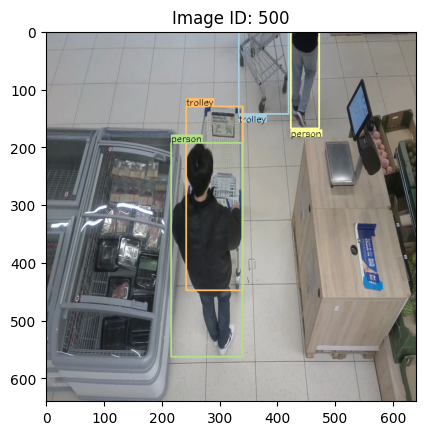

In [5]:
from cocohelper.visualizer import COCOVisualizer

COCOVisualizer(ch).visualize(img_id=500, show_bbox=True, show_segmentation=True)

In [8]:
splitter = ProportionalDataSplitter(70, 20, 10)
ch_train, ch_val, ch_test = splitter.apply(ch)
dest_dir = Path(os.path.join(output_folder, 'annotations'))

for ch, ch_name in zip([ch_train, ch_val, ch_test], ["train", "val", "test"]):
    print(f"Saving dataset: '{ch_name}'")
    fname = dest_dir / f"{ch_name}_640.json"
    ch.write_annotations_file(fname)

Saving dataset: 'train'
Saving dataset: 'val'
Saving dataset: 'test'


# Check if annotations were converted correctly

In [43]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_coco_image(image_id, annotation_file, image_folder, flip_vertical=False):
  """
  Displays a COCO image with its corresponding bounding boxes.

  Args:
      image_id: The ID of the image to display (integer).
      annotation_file: Path to the COCO annotations JSON file (string).
      image_folder: Path to the folder containing the COCO images (string).

  Returns:
      None. Displays the image with bounding boxes using matplotlib.
  """

  # Load COCO annotations
  with open(annotation_file, 'r') as f:
    annotations = json.load(f)

  # Get image information
  images = annotations["images"]
  categories = annotations["categories"]

  # Find the image with the specified ID
  image = None
  for img in images:
    if img["id"] == image_id:
      image = img
      break

  # Check if image was found
  if image is None:
    print(f"Error: Image with ID {image_id} not found in annotations.")
    return

  # Get image path
  image_path = f"{image_folder}/{image['file_name']}"

  # Load the image
  img = plt.imread(image_path)

  # Flip the image vertically if desired
  if flip_vertical:
    img = img[::-1, :]

  # Create the figure and plot the image
  fig, ax = plt.subplots()
  ax.imshow(img)

  # Find annotations for this image
  annotations_list = annotations["annotations"]
  image_annotations = [a for a in annotations_list if a["image_id"] == image_id]

  # Loop through annotations and plot bounding boxes
  for annotation in image_annotations:
    bbox = annotation["bbox"]
    x_min, y_min, width, height = bbox

    # Adjust bounding box coordinates if image is flipped
    if flip_vertical:
      image_height = img.shape[0]
      y_min_flipped = image_height - y_min - height
    else:
      y_min_flipped = y_min

    # Create rectangle patch with (possibly) flipped coordinates
    rectangle = Rectangle(
        xy=(x_min, y_min_flipped),  # Use either original or flipped y_min
        width=width,
        height=height,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )

    # Add the rectangle patch to the plot
    ax.add_patch(rectangle)

    # Optionally, display category information (requires category_id)
    if "category_id" in annotation:
      category_id = annotation["category_id"]
      category_name = [cat["name"] for cat in categories if cat["id"] == category_id][0]
      plt.text(x_min+0.5, y_min_flipped+1, category_name, color='blue', fontsize=10)

  # Set limits slightly higher than the image size to avoid clipping
  plt.xlim(-0.5, img.shape[1] - 0.5)
  plt.ylim(-0.5, img.shape[0] - 0.5)

  # Set axes (optional)
  plt.xlabel("X")
  plt.ylabel("Y")

  # Set title (optional)
  plt.title(f"Image {image['id']}")

  # Display the plot
  plt.show()

In [53]:
image_id = 493
annotation_path = "/Users/johannes/Code/labelstudio/combined_COCO/annotations/train_640.json"
image_dir = "/Users/johannes/Code/labelstudio/combined_COCO"

display_coco_image(image_id, annotation_path, image_dir, flip_vertical=True)


Error: Image with ID 493 not found in annotations.
